In [1]:
!pip install pandas
!pip install spacy
!pip install pandas numpy matplotlib seaborn
!pip install nltk
!pip install gensim
!pip install wordcloud
!pip install scikit-learn
!pip install textblob

In [2]:
import pandas as pd
import csv

df = pd.read_csv("cleaned_reddit_opinion3.csv")

df.head()

/Users/kc/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


,cleaned_text,Lemma,post_title,subreddit,post_score,post_upvote_ratio,post_thumbs_ups
0,Their voices are absolutely beautiful,voice absolutely beautiful,My Hometown GAZA !,Palestine,104,0.98,104
1,I was naming the historical reasons neither eg...,name historical reason neither egypt jordan ...,Why is it so uniquely bad for Palestinians to ...,IsraelPalestine,61,0.75,61
2,Ya got brainwashed pardner,Ya get brainwash pardner,Psychological Warfare,IsraelPalestine,15,0.75,15
3,Are palestinians still living in jordan and eg...,palestinian still live jordan egypt yes egyp...,Why is it so uniquely bad for Palestinians to ...,IsraelPalestine,61,0.75,61
4,The excuse that the palestinians have a valid ...,excuse palestinian valid grievance attack ex...,Thoughts on a refined Clinton Proposal? How wo...,IsraelPalestine,2,0.75,2


In [3]:
import pandas as pd
from textblob import TextBlob

# Step 1: Feature Engineering from Comment Text
df['comment_length'] = df['cleaned_text'].str.len()

#df['comment_sentiment'] = df['cleaned_text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
df['comment_subjectivity'] = df['cleaned_text'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)

# Step 2: Check Correlation with Post Popularity
# You can define "popularity" using any of these
post_popularity_features = ['post_score', 'post_upvote_ratio', 'post_thumbs_ups']

# Just for a quick glance #'comment_sentiment'
print(df[['comment_length', 'comment_subjectivity'] + post_popularity_features].corr())


                      comment_length  comment_subjectivity  post_score  \
comment_length              1.000000              0.116779   -0.091849   
comment_subjectivity        0.116779              1.000000   -0.008480   
post_score                 -0.091849             -0.008480    1.000000   
post_upvote_ratio          -0.170878             -0.031471    0.309481   
post_thumbs_ups            -0.091849             -0.008480    1.000000   

                      post_upvote_ratio  post_thumbs_ups  
comment_length                -0.170878        -0.091849  
comment_subjectivity          -0.031471        -0.008480  
post_score                     0.309481         1.000000  
post_upvote_ratio              1.000000         0.309481  
post_thumbs_ups                0.309481         1.000000  


In [4]:
keywords = ['peace', 'war', 'ceasefire', 'attack', 'support', 'occupation']
for word in keywords:
    df[f'keyword_{word}'] = df['cleaned_text'].str.contains(word, case=False, na=False).astype(int)

In [5]:
!pip install textstat
import textstat

df['readability'] = df['cleaned_text'].apply(lambda x: textstat.flesch_reading_ease(str(x)))


In [6]:
df[['cleaned_text', 'readability']].head()


,cleaned_text,readability
0,Their voices are absolutely beautiful,15.64
1,I was naming the historical reasons neither eg...,30.20
2,Ya got brainwashed pardner,75.88
3,Are palestinians still living in jordan and eg...,40.69
4,The excuse that the palestinians have a valid ...,35.62


In [7]:
feature_columns = ['cleaned_text', 'comment_length', 'readability'] + [col for col in df.columns if col.startswith('keyword_')]

df[feature_columns].head(10) 


,cleaned_text,comment_length,readability,keyword_peace,keyword_war,keyword_ceasefire,keyword_attack,keyword_support,keyword_occupation
0,Their voices are absolutely beautiful,37.0,15.64,0,0,0,0,0,0
1,I was naming the historical reasons neither eg...,143.0,30.20,0,0,0,0,0,0
2,Ya got brainwashed pardner,26.0,75.88,0,0,0,0,0,0
3,Are palestinians still living in jordan and eg...,130.0,40.69,0,0,0,0,0,0
4,The excuse that the palestinians have a valid ...,288.0,35.62,0,1,0,1,0,0
5,Yes it is a reason to kill terrorists yes gaza...,334.0,0.76,0,1,0,0,0,0
6,Palestinians fought in the ottoman army agains...,285.0,7.87,0,0,0,0,1,0
7,I approve of this message,25.0,83.32,0,0,0,0,0,0
8,Banking is not a crime its what jews ended up ...,327.0,22.08,0,0,0,0,0,0
9,Which makes it bit off they control so much te...,635.0,-39.17,0,0,0,0,1,0


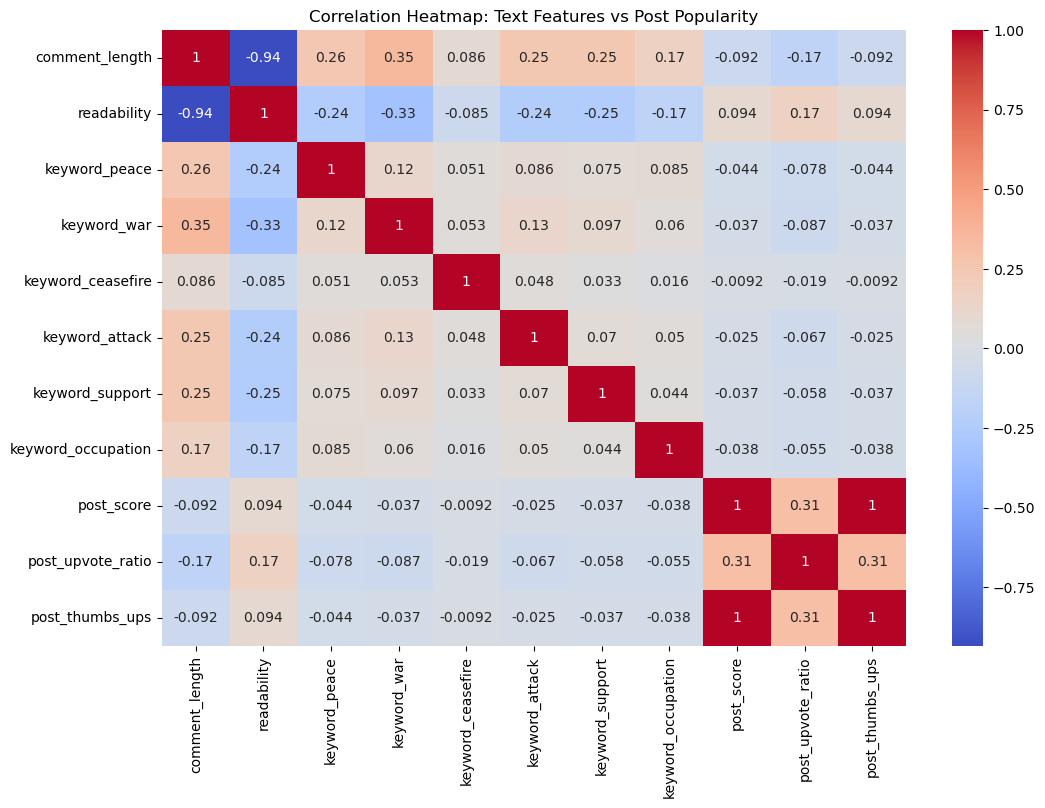

In [9]:
# Filter only numeric columns
numeric_df = df[feature_columns + post_popularity_features].select_dtypes(include='number')

# Plot the heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap: Text Features vs Post Popularity')
plt.show()


Readability: Readability shows a slightly better relationship, which is interesting! Slight positive — easier-to-read comments tend to appear under slightly more popular posts.

Comment length: Slight negative — longer comments are not found under higher-scoring posts (maybe shorter, punchier comments are more common).

In [10]:
import nltk
from nltk.corpus import stopwords
from gensim import corpora, models
from gensim.models.ldamodel import LdaModel

df['lemma_tokens'] = df['Lemma'].apply(
    lambda x: [word for word in str(x).lower().split() if word.isalpha() and word not in stopwords.words('english')]
)

In [11]:
from gensim import corpora, models
from gensim.models.ldamodel import LdaModel

# Create dictionary and corpus from lemmatized tokens
dictionary = corpora.Dictionary(df['lemma_tokens'])
corpus = [dictionary.doc2bow(text) for text in df['lemma_tokens']]

# Train LDA
lda_model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=4,
                     random_state=42,
                     passes=10)

# Show topics
for idx, topic in lda_model.print_topics(num_words=6):
    print(f"Topic {idx}: {topic}")


Topic 0: 0.045*"hamas" + 0.025*"israel" + 0.018*"gaza" + 0.016*"kill" + 0.016*"civilian" + 0.011*"people"
Topic 1: 0.025*"israel" + 0.020*"palestinian" + 0.017*"jew" + 0.017*"people" + 0.012*"palestine" + 0.012*"state"
Topic 2: 0.019*"us" + 0.013*"israel" + 0.011*"would" + 0.010*"war" + 0.010*"country" + 0.009*"get"
Topic 3: 0.016*"like" + 0.014*"people" + 0.012*"get" + 0.012*"say" + 0.011*"see" + 0.010*"know"


In [12]:
def get_topic_distribution(bow):
    topic_dist = lda_model.get_document_topics(bow, minimum_probability=0)
    return [prob for _, prob in topic_dist]

topic_distributions = [get_topic_distribution(bow) for bow in corpus]

# Add to dataframe
import numpy as np
topic_df = pd.DataFrame(topic_distributions, columns=[f'Topic_{i}' for i in range(lda_model.num_topics)])
df = pd.concat([df.reset_index(drop=True), topic_df.reset_index(drop=True)], axis=1)

df


,cleaned_text,Lemma,post_title,subreddit,post_score,post_upvote_ratio,post_thumbs_ups,comment_length,comment_subjectivity,keyword_peace,...,keyword_ceasefire,keyword_attack,keyword_support,keyword_occupation,readability,lemma_tokens,Topic_0,Topic_1,Topic_2,Topic_3
0,Their voices are absolutely beautiful,voice absolutely beautiful,My Hometown GAZA !,Palestine,104,0.98,104,37.0,1.000000,0,...,0,0,0,0,15.64,"[voice, absolutely, beautiful]",0.063452,0.064155,0.063159,0.809233
1,I was naming the historical reasons neither eg...,name historical reason neither egypt jordan ...,Why is it so uniquely bad for Palestinians to ...,IsraelPalestine,61,0.75,61,143.0,0.300000,0,...,0,0,0,0,30.20,"[name, historical, reason, neither, egypt, jor...",0.018495,0.944668,0.018465,0.018373
2,Ya got brainwashed pardner,Ya get brainwash pardner,Psychological Warfare,IsraelPalestine,15,0.75,15,26.0,0.000000,0,...,0,0,0,0,75.88,"[ya, get, brainwash, pardner]",0.062647,0.062842,0.063306,0.811205
3,Are palestinians still living in jordan and eg...,palestinian still live jordan egypt yes egyp...,Why is it so uniquely bad for Palestinians to ...,IsraelPalestine,61,0.75,61,130.0,0.066667,0,...,0,0,0,0,40.69,"[palestinian, still, live, jordan, egypt, yes,...",0.019732,0.668859,0.292897,0.018511
4,The excuse that the palestinians have a valid ...,excuse palestinian valid grievance attack ex...,Thoughts on a refined Clinton Proposal? How wo...,IsraelPalestine,2,0.75,2,288.0,0.081250,0,...,0,1,0,0,35.62,"[excuse, palestinian, valid, grievance, attack...",0.460482,0.515611,0.012037,0.011870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2369529,Something similar happened in sweden recently,Something similar happen sweden recently,Eritrean immigrants (illegals) fighting in the...,ActualPublicFreakouts,597,0.94,597,45.0,0.325000,0,...,0,0,0,0,14.63,"[something, similar, happen, sweden, recently]",0.043188,0.043553,0.867123,0.046136
2369530,They should leave the anger and hatred back wh...,leave anger hatred back come probably one ma...,Eritrean immigrants (illegals) fighting in the...,ActualPublicFreakouts,597,0.94,597,145.0,0.258333,0,...,0,0,0,0,68.44,"[leave, anger, hatred, back, come, probably, o...",0.018885,0.755567,0.206393,0.019155
2369531,Something similar happened in germany recently,Something similar happen germany recently,Eritrean immigrants (illegals) fighting in the...,ActualPublicFreakouts,597,0.94,597,46.0,0.325000,0,...,0,0,0,0,6.17,"[something, similar, happen, germany, recently]",0.043183,0.044005,0.866638,0.046173
2369532,Who are the yellow shirts the referees,yellow shirt referee,Eritrean immigrants (illegals) fighting in the...,ActualPublicFreakouts,597,0.94,597,38.0,0.000000,0,...,0,0,0,0,81.29,"[yellow, shirt, referee]",0.062842,0.062842,0.062842,0.811474


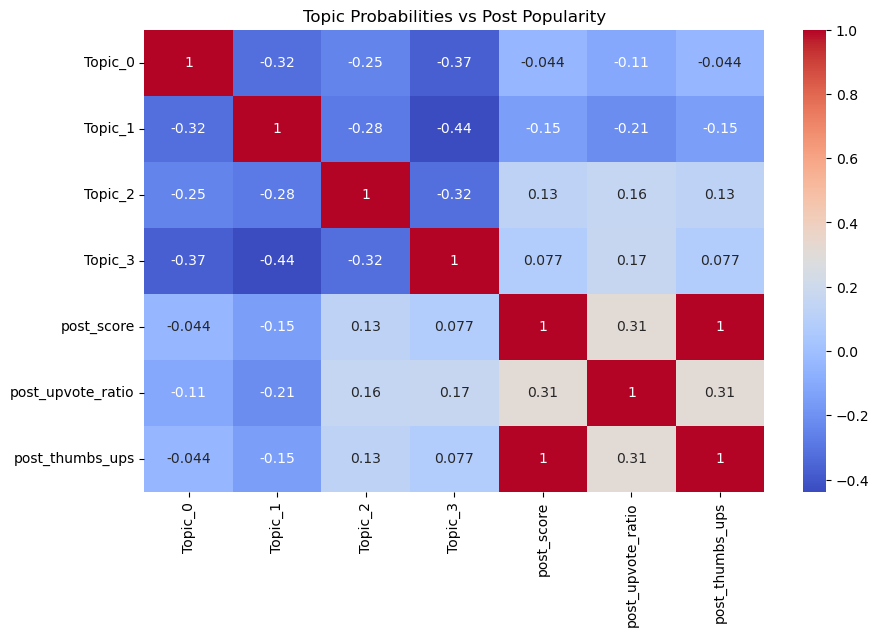

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation matrix: topics vs post metrics
topic_cols = [f'Topic_{i}' for i in range(lda_model.num_topics)]
post_popularity_features = ['post_score', 'post_upvote_ratio', 'post_thumbs_ups']

plt.figure(figsize=(10, 6))
sns.heatmap(df[topic_cols + post_popularity_features].corr(), annot=True, cmap='coolwarm')
plt.title("Topic Probabilities vs Post Popularity")
plt.show()


Topic 2: 0.019*"us" + 0.013*"israel" + 0.011*"would" + 0.010*"war" + 0.010*"country" + 0.009*"get"
Topic 3: 0.016*"like" + 0.014*"people" + 0.012*"get" + 0.012*"say" + 0.011*"see" + 0.010*"know"

In [14]:
from sklearn.linear_model import LinearRegression
X = df[['Topic_0', 'Topic_1', 'Topic_2', 'Topic_3']]  # LDA topics
y = df['post_score']

model = LinearRegression()
model.fit(X, y)
print(f"R^2: {model.score(X, y)}")


R^2: 0.03548104136369479


The R² value of 0.03 you got from the linear regression model indicates that only 3% of the variance in post score (or engagement) is explained by the topics (Topic 0, Topic 1, Topic 2, Topic 3). The low R² suggests that LDA topics alone do not explain a significant portion of post popularity.

In [15]:
print(df[['Topic_0', 'Topic_1', 'Topic_2', 'Topic_3', 'post_score']].corr())


             Topic_0   Topic_1   Topic_2   Topic_3  post_score
Topic_0     1.000000 -0.319924 -0.248241 -0.371474   -0.044170
Topic_1    -0.319924  1.000000 -0.281964 -0.437725   -0.150517
Topic_2    -0.248241 -0.281964  1.000000 -0.323919    0.128634
Topic_3    -0.371474 -0.437725 -0.323919  1.000000    0.077006
post_score -0.044170 -0.150517  0.128634  0.077006    1.000000


Topic 0: Likely related to conflict and violence (e.g., references to Hamas, Israel, and Gaza).

Topic 1: More focused on politics and geopolitical relations (e.g., Israel, Palestinians, and the region).

Topic 2: Focuses on political discourse or international relations (mentions of "war", "us", and "country").

Topic 3: Appears to be related to social discussions, possibly on the public opinion or perceptions (words like "like", "people", and "say").

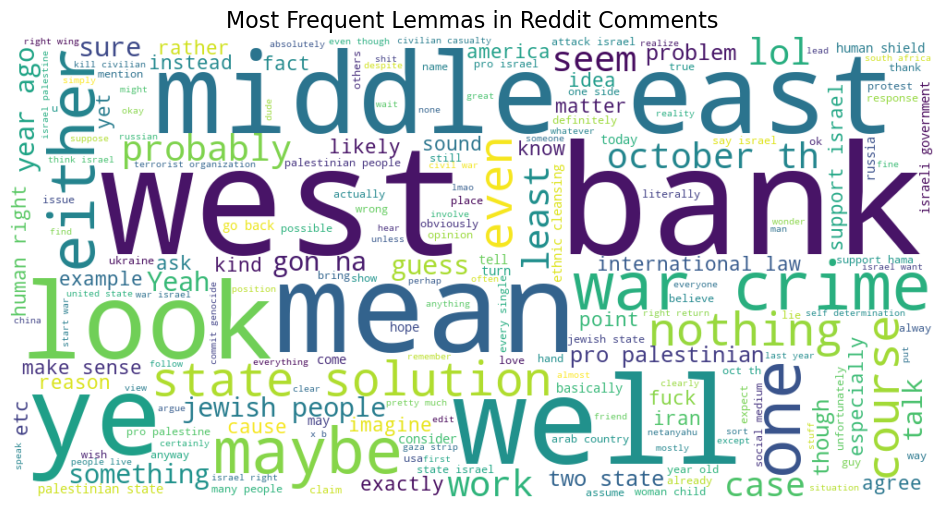

In [16]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all lemmas into a single string
all_text = " ".join(df['Lemma'].dropna().astype(str))

# Generate the word cloud
wordcloud = WordCloud(width=1000, height=500, background_color='white', colormap='viridis').generate(all_text)

# Plot the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Frequent Lemmas in Reddit Comments", fontsize=16)
plt.show()


In [17]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import gensim

nltk.download('punkt')
nltk.download('stopwords')

# Define tokenization and cleaning functions
stop_words = set(stopwords.words('english'))

def preprocess(text):
    tokens = word_tokenize(text)
    return [token.lower() for token in tokens if token.isalpha() and token.lower() not in stop_words]

# Apply preprocessing to the Lemma text
df['processed_tokens'] = df['Lemma'].apply(preprocess)

# Create a dictionary and corpus from the processed text
dictionary = Dictionary(df['processed_tokens'])
corpus = [dictionary.doc2bow(text) for text in df['processed_tokens']]


[nltk_data] Downloading package punkt to /Users/kc/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/kc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:

lda_model = LdaModel(corpus, id2word=dictionary, num_topics=4, random_state=42, passes=10)

# Display the topics
topics = lda_model.print_topics(num_words=6)  # Show top 6 words in each topic
for topic in topics:
    print(topic)


(0, '0.045*"hamas" + 0.025*"israel" + 0.018*"gaza" + 0.016*"kill" + 0.016*"civilian" + 0.011*"people"')
(1, '0.025*"israel" + 0.020*"palestinian" + 0.017*"jew" + 0.017*"people" + 0.012*"palestine" + 0.012*"state"')
(2, '0.019*"us" + 0.013*"israel" + 0.011*"would" + 0.010*"war" + 0.010*"country" + 0.009*"get"')
(3, '0.016*"like" + 0.014*"people" + 0.012*"get" + 0.012*"say" + 0.011*"see" + 0.010*"know"')


In [19]:
# Assign topic probabilities to each comment
def get_topic_probabilities(text):
    bow = dictionary.doc2bow(text)
    topic_probabilities = lda_model.get_document_topics(bow)
    return dict(topic_probabilities)

df['topic_probabilities'] = df['processed_tokens'].apply(get_topic_probabilities)



In [20]:
X = df[['Topic_0', 'Topic_1', 'Topic_2', 'Topic_3']]  # Make sure these columns exist
y = df['post_score']

model = LinearRegression()
model.fit(X, y)
print(f"R^2: {model.score(X, y)}")

R^2: 0.03548104136369479
